In [196]:
import xarray as xr
import pandas as pd
import numpy as np
import meitner
import warnings

import matplotlib.pyplot as plt

from vamas import Vamas

In [197]:
file = 'sh_all.vms'

In [198]:
data0 = meitner.Xps.from_vamas(path=file, region_id=6)
data1 = meitner.Xps.from_vamas(path=file, region_id=14)
xps_list = [data0,data1]

Found 43 blocks.

Detected multiple VAMAS blocks with the same name.

Excitation energy:
1486.69 eV
Found 43 blocks.

Detected multiple VAMAS blocks with the same name.

Excitation energy:
1486.69 eV


In [199]:
fit = meitner.Fit(xps_list, n_peaks=2, first_peak_index=0)

[<meitner.Xps object at 0x28f285cd0>, <meitner.Xps object at 0x28f220f40>]
2
<xarray.DataArray 'residual' (be: 402)>
array([-6.11579767e-03, -6.14232151e-03, -6.10124455e-03, -6.63145559e-03,
       -6.27818731e-03, -6.43536505e-03, -7.05900626e-03, -7.46849785e-03,
       -7.68464260e-03, -7.61999474e-03, -7.95320789e-03, -7.60797884e-03,
       -8.05489261e-03, -8.46569252e-03, -9.09752249e-03, -9.19023852e-03,
       -9.43770223e-03, -9.31783369e-03, -1.05949703e-02, -1.07099757e-02,
       -1.15187727e-02, -1.13883394e-02, -1.25709110e-02, -1.23797217e-02,
       -1.34742092e-02, -1.42318638e-02, -1.47921591e-02, -1.61347079e-02,
       -1.76885031e-02, -1.79512840e-02, -1.85969967e-02, -1.98519754e-02,
       -2.01018156e-02, -2.07237021e-02, -2.15078872e-02, -2.16127406e-02,
       -2.17017670e-02, -2.11438662e-02, -2.03968417e-02, -1.98986772e-02,
       -1.82068466e-02, -1.71148542e-02, -1.76244861e-02, -1.68497256e-02,
       -1.79134920e-02, -1.94013370e-02, -2.20407985e-02, 

In [204]:
fit.result

In [241]:
file1 = 'au3-0001.pxt.vms'
xps1 = meitner.Xps.from_vamas(path=file1, region_id=1)

Found 2 blocks.

Excitation energy:
655.0 eV


In [259]:
# expr_constraints = {'d0_p0_amplitude': {'value': 0.5, 'min': 0, 'max': 1},
#                     'd0_p1_amplitude': {'value': 0.5*3/4, 'min': 0, 'max': 1},
#                     'd0_p0_center': {'value': 83, 'min': 82, 'max': 84},
#                     'd0_p1_center': {'value': 86.5, 'min': 85, 'max': 88},
#                     'd0_p0_sigma': {'value': 0.5, 'min': 0, 'max': 1.5},
#                     'd0_p1_sigma': {'value': 0.5, 'min': 0, 'max': 1.5},
#                     'd0_p0_gamma': {'value': 0.5, 'min': 0, 'max': 1.5},
#                     'd0_p1_gamma': {'value': 0.5, 'min': 0, 'max': 1.5}}
expr_constraints = {'d0_p0_amplitude': {'value': 0.5, 'min': 0, 'max': 1},
                    'd0_p1_amplitude': {'value': 0.5, 'min': 0, 'max': 1},
                    'd0_p0_center': {'value': 84, 'min': 80, 'max': 92},
                    'd0_p1_center': {'value': 88, 'min': 80, 'max': 92},
                    'd0_p0_sigma': {'value': 0.1, 'min': 10**-8, 'max': 1.5},
                    'd0_p1_sigma': {'value': 0.1, 'min': 10**-8, 'max': 1.5},
                    'd0_p0_gamma': {'value': 0.1, 'min': 10**-8, 'max': 1.5},
                    'd0_p1_gamma': {'value': 0.1, 'min': 10**-8, 'max': 1.5}}
# expr_constraints = {'d0_p0_center': {'value': 83, 'min': 82, 'max': 84},
#                     'd0_p1_center': {'value': 86.5, 'min': 85, 'max': 88}}
fit0 = meitner.Fit(xps1, n_peaks=2, first_peak_index=0, fit=True, be_guess=[83,88],
                   expr_constraints=expr_constraints, method='leastsq')

1


In [262]:
fit0.result

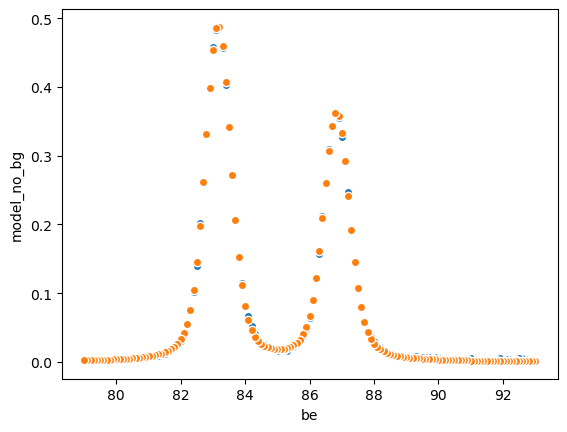

In [261]:
fig, ax = plt.subplots()
fit0.xps['d0'].ds.plot.scatter(x='be',y='cps_no_bg_norm',ax=ax)
fit0.xps['d0'].ds.plot.scatter(x='be',y='model_no_bg',ax=ax)

In [255]:
expr_constraints = {'d0_p0_amplitude': {'value': 0.5, 'min': 0, 'max': 1},
                    'd0_p1_amplitude': {'value': 0.5, 'min': 0, 'max': 1},
                    'd0_p0_center': {'value': 84, 'min': 80, 'max': 92},
                    'd0_p1_center': {'value': 88, 'min': 80, 'max': 92},
                    'd0_p0_sigma': {'value': 0.1, 'min': 10**-8, 'max': 1.5},
                    'd0_p1_sigma': {'value': 0.1, 'min': 10**-8, 'max': 1.5},
                    'd0_p0_gamma': {'value': 0.1, 'min': 10**-8, 'max': 1.5},
                    'd0_p1_gamma': {'value': 0.1, 'min': 10**-8, 'max': 1.5}}
# expr_constraints = {'d0_p0_center': {'value': 83, 'min': 82, 'max': 84},
#                     'd0_p1_center': {'value': 86.5, 'min': 85, 'max': 88}}
fit1 = meitner.Fit(xps1, n_peaks=2, first_peak_index=0, fit=True, be_guess=[83,88],
                   expr_constraints=expr_constraints, method='dual_annealing')

1


In [263]:
fit1.result

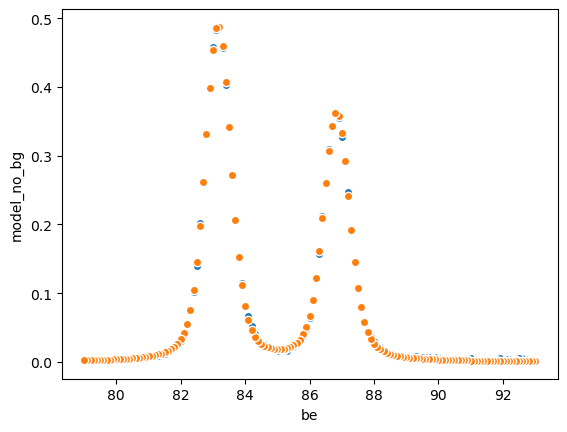

In [256]:
fig, ax = plt.subplots()
fit1.xps['d0'].ds.plot.scatter(x='be',y='cps_no_bg_norm',ax=ax)
fit1.xps['d0'].ds.plot.scatter(x='be',y='model_no_bg',ax=ax)